# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [4]:
import json
import requests
import random
import string
import secrets
import time
import re
from builtins import list
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 

In [6]:
vowels = ['a', 'e', 'i', 'o', 'u']
def countVowels(word):
    count =0 #count of vowels
    for ch in word:
        if ch in vowels:
            count+=1.0
    return count/len(word)

def is_vowel_present(vowel,word):
    if vowel in word:
        return True
    return False
# count of a given vowel in word/total length of word
def countVowel(word,vowel):
    count = 0
    for char in word:
        if char==vowel:
            count+=1.00
    return count/len(word)

In [7]:
data = open("words_250000_train.txt","r")
word_list=[]
for word in data:
    word_list.append(word.replace("\n",""))
headItems=pd.DataFrame(word_list).head()[1:]
listOfWords=pd.Series(word_list)
listOfWords.describe()
print(headItems)


        0
1  aaaaaa
2    aaas
3  aachen
4    aaee


In [8]:
# getting info about vowels and its distribution
vowel_distrib = []
for word in word_list:
   # print(word,countVowels(word))
    vowel_distrib.append(countVowels(word))
vowel_distrib= pd.Series(vowel_distrib)
vowel_distrib.describe()

count    227300.000000
mean          0.386889
std           0.095527
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64

Text(0, 0.5, 'Count')

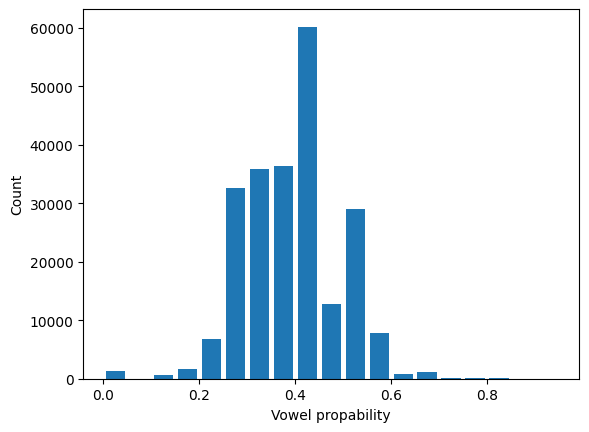

In [9]:
bins = np.arange(0.0,1.0,0.05)
plt.hist(vowel_distrib,bins,rwidth=0.8)
plt.xlabel("Vowel propability")
plt.ylabel('Count')

In [10]:
# This depicts that when vowels are 0.45 times or greater than total length, the count of such words is less 
# and thus choosing vowels in such words is not great choice

In [11]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        self.vowels=['a','e','i','o','u']        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []

        self.current_n_word_dictionary = self.build_my_dictionary(self.full_dictionary)
        self.setOfLetters = sorted(set("".join(self.full_dictionary)))
        self.probabilities = [0] * len(self.setOfLetters)
        self.unigram, self.bigram, self.trigram, self.fourgram, self.fivegram = self.build_n_grams(self.full_dictionary)
        self.normalized_probabilities = []
        self.wins = []
        self.incorrect_words = []
        self.variable_parameter = 1
        self.unigram_lambda = 0.10 * self.variable_parameter
        self.bigram_lambda = 0.20 * self.variable_parameter
        self.trigram_lambda = 0.30 * self.variable_parameter
        self.fourgram_lambda = 0.40 * self.variable_parameter
        self.fivegram_lambda = 0.45 * self.variable_parameter
        random_seed = random.randint(1,1000)
        random.seed(random_seed)

    def optimize_em(prob_matrix: np.array, n_iter: int, init_weights: list = None) -> np.array:
        """
        Optimize model weights using EM algorithm
        :param init_weights: initial weights. If None, all models will have equal initial weights.
        :param prob_matrix: probability matrix of n_words x n_models.
        :param n_iter: number of iterations to run EM
        :return: model weights after running EM
        """
        # Initialization of Model Weights
        if init_weights is not None:
            weights = np.array(init_weights)
        else:
            n_models = prob_matrix.shape[1]
            weights = np.ones(n_models) / n_models

        for iteration in range(n_iter):
            # E-step: calculate posterior probabilities from current model weights
            weighted_probs = prob_matrix * weights
            total_probs = weighted_probs.sum(axis=1, keepdims=True)
            posterior_probs = weighted_probs / total_probs

            # M-step: update model weights using posterior probabilities from E-step
            weights = posterior_probs.mean(axis=0)

        return weights
    '''"
        N-gram Model  : building n-grams, calibration of dictionary, calculation of required probabilites, optimisation using statistic results
    '''
    def build_n_grams(self, dict):
        '''
            building dictionary containing n (1-5) sequences of letters 
        '''

        # array of 1-D vector 
        unigram = collections.defaultdict(lambda: collections.defaultdict(int))
        # array of 2-D vector
        bi_gram = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
        tri_gram = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
        # array of 3-D vector
        four_gram = collections.defaultdict(lambda:collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int))))
        # array of 4-D vector
        five_gram = collections.defaultdict(lambda: collections.defaultdict(lambda:collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))))

        # building the n-gram
        for word in dict:
            for char in set(word):
                unigram[len(word)][char] += 1

            for ind in range(len(word)-4):
                bi_gram[len(word)][word[ind]][word[ind+1]] += 1
                tri_gram[word[ind]][word[ind+1]][word[ind+2]] += 1
                four_gram[word[ind]][word[ind+1]][word[ind+2]][word[ind+3]] += 1
                five_gram[word[ind]][word[ind+1]][word[ind+2]][word[ind+3]][word[ind+4]] += 1
            curLen = len(word)-4

            if len(word) == 2:
                bi_gram[len(word)][word[0]][word[1]] += 1
            elif len(word) == 3:
                bi_gram[len(word)][word[0]][word[1]] += 1
                bi_gram[len(word)][word[1]][word[2]] += 1
                tri_gram[word[0]][word[1]][word[2]] += 1
                
            elif len(word) >= 4:
                bi_gram[len(word)][word[curLen]][word[curLen+1]] += 1
                bi_gram[len(word)][word[curLen+1]][word[curLen+2]] += 1
                bi_gram[len(word)][word[curLen+2]][word[curLen+3]] += 1
                tri_gram[word[curLen]][word[curLen+1]][word[curLen+2]] += 1
                tri_gram[word[curLen+1]][word[curLen+2]][word[curLen+3]] += 1
                four_gram[word[curLen]][word[curLen+1]][word[curLen+2]][word[curLen+3]] += 1
            
        return unigram, bi_gram, tri_gram, four_gram, five_gram
    
    def recalibrate_n_grams(self):
        ''' 
         re-tabulates the n-grams after eliminating any incorrectly guessed letters and updates the dictionary to remvoe words containing incorrectly guessed letters
        '''
        new_dict = [word for word in self.full_dictionary if not set(word).intersection(set(self.incorrect_words))]
        self.unigram, self.bigram, self.trigram, self.fourgram, self.fivegram = self.build_n_grams(new_dict)

    def unigram_probs(self, word):
        probs = [0]* len(self.setOfLetters)
        total_count = 0
        letter_count = [0] * len(self.setOfLetters)

        for i in range(len(word)):
            if word[i] == '.':
                for j,letter in enumerate(self.setOfLetters):
                    if self.unigram[len(word)][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.unigram[len(word)][letter]
                        letter_count[j] += self.unigram[len(word)][letter]

        # calculation of probabilities
        if total_count > 0:
            for i in range(len(self.setOfLetters)):
                probs[i] = (1.0*letter_count[i]) / (total_count*1.0)

        # interpolate probabilities : current_probability + probability[i]*(its weightage)
        for i,curProb in enumerate(self.probabilities):
            self.probabilities[i] = curProb + probs[i]*(self.unigram_lambda)

        # normalization of probabilities: so that it sums to 1
        final_probs = [0]*len(self.setOfLetters)
        totSum = sum(self.probabilities)
        if sum(self.probabilities) > 0:
            for i in range(len(self.probabilities)):
                final_probs[i] = self.probabilities[i] / totSum

        self.probabilities = final_probs

        # finding the letter with max probability
        max_prob = 0
        guess_letter = ''
        for i,letter in enumerate(self.setOfLetters):
            if self.probabilities[i] > max_prob:
                max_prob = self.probabilities[i]
                guess_letter = letter

        clean_word = ''
        for char in word:
            if char != '.':
                clean_word += char

        count_of_vowels = self.vowel_count(clean_word)
        # if no letter is choosen from above, pick a random one (vowels are weighted more if len(vowels_found)/len(word) < 0.55)
        if guess_letter == '':
            letters = self.setOfLetters.copy()
            random.shuffle(letters)
            letters_shuffled = letters    
            if count_of_vowels < 0.46 or len(word) < 4: # and count_of_vowels > 0.187:
                letters_shuffled = self.vowels + letters
                random.shuffle(letters_shuffled)
                for letter in letters_shuffled:
                    if letter not in self.guessed_letters:
                        return letter
            else:
                for letter in letters_shuffled:
                    if letter not in self.guessed_letters:
                        return letter
                
        return guess_letter
    
    def bigram_probs(self, word):
        '''
            calculate the probability of a certain letter appearing in a two-letter sequence for a word of given length 
        '''
        prob = [0] * len(self.setOfLetters)
        total_count = 0
        letter_count = [0]* len(self.setOfLetters)
        
        for ind in range(len(word)-1):
            if word[ind] != '.' and word[ind+1] == '.':
                basis_letter = word[ind]

                for j, letter in enumerate(self.setOfLetters):
                    if self.bigram[len(word)][basis_letter][letter] > 0 and letter not in self.incorrect_words:
                        total_count += self.bigram[len(word)][basis_letter][letter]
                        letter_count[j] += self.bigram[len(word)][basis_letter][letter]
    
            elif word[ind] == '.' and word[ind+1] != '.':
                basis_letter = word[ind+1]

                for j, letter in enumerate(self.setOfLetters):
                    if self.bigram[len(word)][letter][basis_letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.bigram[len(word)][letter][basis_letter]
                        letter_count[j] += self.bigram[len(word)][letter][basis_letter]

        # calculation of probabilites, interpolate the probabilites between trigram and bigram
        # normalization of probabilites
        if total_count > 0:
            for i in range(len(self.setOfLetters)):
                prob[i] = (1.0*letter_count[i])/(total_count*1.0)
    
        for i,curProb in enumerate(self.probabilities):
            self.probabilities[i] = curProb + (prob[i]*self.bigram_lambda)

        return self.unigram_probs(word)


    def trigram_probs(self, word):
        '''
            calculation of probabilities of certain letter appearing in 3 letter sequence
        '''
        
        prob = [0] * len(self.setOfLetters)
        total_count = 0
        letter_count = [0] * len(self.setOfLetters)

        for ind in range(len(word) - 2):
            if word[ind] != '.' and word[ind+1] != '.' and word[ind+2] == '.':
                basis_letter = [word[ind], word[ind+1]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.trigram[basis_letter[0]][basis_letter[1]][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[basis_letter[0]][basis_letter[1]][letter]
                        letter_count[j] += self.trigram[basis_letter[0]][basis_letter[1]][letter]
        
            elif word[ind] != '.' and word[ind+1] == '.' and word[ind+2] != '.':
                basis_letter = [word[ind], word[ind+2]]
                for j, letter in enumerate(self.setOfLetters):
                    if self.trigram[basis_letter[0]][letter][basis_letter[1]] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[basis_letter[0]][letter][basis_letter[1]]
                        letter_count[j] += self.trigram[basis_letter[0]][letter][basis_letter[1]]
                       
            elif word[ind] == '.' and word[ind+1] != '.' and word[ind+2] != '.':
                basis_letter = [word[ind+1], word[ind+2]]
                for j, letter in enumerate(self.setOfLetters):
                    if self.trigram[letter][basis_letter[0]][basis_letter[1]] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[letter][basis_letter[0]][basis_letter[1]]
                        letter_count[j] += self.trigram[letter][basis_letter[0]][basis_letter[1]]
              
        # calculate the probabilities, interpolation and as I did above
        if total_count > 0:
            for i in range(len(self.setOfLetters)):
                prob[i] = letter_count[i] / total_count
        
        for i, curProb in enumerate(self.probabilities):
            self.probabilities[i] = curProb + prob[i] * (self.trigram_lambda)
        
        return self.bigram_probs(word)
    
    def fourgram_probs(self, word):
        ''' 
            calculation of probabilities of certain letter appearing in 4 letter sequence using trigram
        '''
                
        prob = [0] * len(self.setOfLetters)
        total_count = 0
        letter_count = [0] * len(self.setOfLetters)

        for ind in range(len(word) - 3):
            if word[ind] != '.' and word[ind+1] != '.' and word[ind+2] != '.' and word[ind+3] == '.':
                basis_letter = [word[ind], word[ind+1], word[ind+2]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fourgram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter]
                        letter_count[j] += self.fourgram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter]
        
            elif word[ind] != '.' and word[ind+1] != '.' and word[ind+2] == '.' and word[ind+3] != '.':
                basis_letter = [word[ind], word[ind+1], word[ind+3]]
              
                for j, letter in enumerate(self.setOfLetters):
                    if self.fourgram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]]
                        letter_count[j] += self.fourgram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]]
  
            elif word[ind] != '.' and word[ind+1] == '.' and word[ind+2] != '.' and word[ind+2] != '.':
                basis_letter = [word[ind], word[ind+2], word[ind+3]]
              
                for j, letter in enumerate(self.setOfLetters):
                    if self.fourgram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]]
                        letter_count[j] += self.fourgram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]]
  
            elif word[ind] == '.' and word[ind+1] != '.' and word[ind+2] != '.' and word[ind+3] != '.':
                basis_letter = [word[ind+1], word[ind+2], word[ind+3]]
              
                for j, letter in enumerate(self.setOfLetters):
                    if self.fourgram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]]
                        letter_count[j] += self.fourgram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]]
  
        if total_count > 0:
            for i in range(len(self.setOfLetters)):
                prob[i] = letter_count[i] / total_count
        for i, curProb in enumerate(self.probabilities):
            self.probabilities[i] = curProb + (prob[i] * (self.fourgram_lambda))
        
        return self.trigram_probs(word)
    def fivegram_probs(self, word):
        ''' 
             calculation of probabilities of certain letter appearing in 5 letter sequence using fourgram
        '''
        prob = [0] * len(self.setOfLetters)
        total_count = 0
        letter_count = [0] * len(self.setOfLetters)

        for ind in range(len(word) - 4):
            if word[ind] != '.' and word[ind+1] != '.' and word[ind+2] != '.' and word[ind+3] != '.' and word[ind+4] == '.':
                basis_letter = [word[ind], word[ind+1], word[ind+2], word[ind+3]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]][letter]
                        letter_count[j] += self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]][letter]
        
            elif word[ind] != '.' and word[ind+1] != '.' and word[ind+2] != '.' and word[ind+3] == '.' and word[ind+4] != '.':
                basis_letter = [word[ind], word[ind+1], word[ind+2], word[ind+4]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter][basis_letter[3]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter][basis_letter[3]]
                        letter_count[j] += self.fivegram[basis_letter[0]][basis_letter[1]][basis_letter[2]][letter][basis_letter[3]]
               
            elif word[ind] != '.' and word[ind+1] != '.' and word[ind+2] == '.' and word[ind+2] != '.' and word[ind+2] != '.':
                basis_letter = [word[ind], word[ind+1], word[ind+3], word[ind+4]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fivegram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]][basis_letter[3]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]][basis_letter[3]]
                        letter_count[j] += self.fivegram[basis_letter[0]][basis_letter[1]][letter][basis_letter[2]][basis_letter[3]]
               
            elif word[ind] != '.' and word[ind+1] == '.' and word[ind+2] != '.' and word[ind+2] != '.' and word[ind+2] != '.':
                basis_letter = [word[ind], word[ind+2], word[ind+3], word[ind+4]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fivegram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]][basis_letter[3]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]][basis_letter[3]]
                        letter_count[j] += self.fivegram[basis_letter[0]][letter][basis_letter[1]][basis_letter[2]][basis_letter[3]]
        
            elif word[ind] == '.' and word[ind+1] != '.' and word[ind+2] != '.' and word[ind+2] != '.' and word[ind+2] != '.':
                basis_letter = [word[ind+1], word[ind+2], word[ind+3], word[ind+4]]
                
                for j, letter in enumerate(self.setOfLetters):
                    if self.fivegram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]]
                        letter_count[j] += self.fivegram[letter][basis_letter[0]][basis_letter[1]][basis_letter[2]][basis_letter[3]]
        
        if total_count > 0:
            for i in range(len(self.setOfLetters)):
                prob[i] = letter_count[i] / total_count
        
        for i, curProb in enumerate(self.probabilities):
            self.probabilities[i] = curProb + (prob[i] * (self.fivegram_lambda))
        
        return self.fourgram_probs(word)
    
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    

    # store 3 length possible substrings : _p_ determining prob for this
    def build_my_dictionary(self, parent_dictionary):
        max_length_of_word = self.find_max_length(parent_dictionary)
        current_n_word_dictionary={i: [] for i in range(3,max_length_of_word+1)}
        for count in range(3,max_length_of_word + 1):
            for word in parent_dictionary:
                if len(word) >= count:
                    for i in range(len(word)-count+1):
                        current_n_word_dictionary[count].append(word[i:i + count])
        return current_n_word_dictionary
        
    def find_max_length(self, word_list):
        max_length=0
        for word in word_list:
            if len(word) > max_length:
                max_length = len(word)
        return max_length
        

    def vowel_count(self, word):
        if len(word) <=0:
            return 0.00
        count = 0.00
        for char in word:
            if char in vowels:
                count += 1
        return count/len(word)
    #{key:val} here, val stores the count of key in all the words of new_dictionary 
    def store_counts(self,new_dictionary):
        frequency = collections.Counter()
        for word in new_dictionary:
            temp = collections.Counter(word)
            for i in temp:
                temp[i]=1
            frequency = frequency + temp
        return frequency
        
    # building new dictionary from the current word (after filling up some gaps)
    def create_concise_dictionary(self, word, current_dict ):
        new_dict = []
        for curWord in current_dict[len(word)]:
            if re.match(word,curWord):
                new_dict.append(curWord)
        return new_dict

    def guess(self, word, tries_remains): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")

        # keeping track of incorrect guesses
        self.incorrect_words = list(set(self.guessed_letters)-set(clean_word))
        self.probabilities = [0]*len(self.setOfLetters)

        if len(self.guessed_letters) > 0 and self.guessed_letters[-1] in self.incorrect_words and tries_remains%2 == 1:
            self.recalibrate_n_grams()

        if len(word) < 5:
            if len(word) == 1:
                return self.unigram_probs(clean_word)
            if len(word) == 2:
                return self.bigram_probs(clean_word)
            elif len(word) == 3:
                return self.trigram_probs(clean_word)
            elif len(word) == 4:
                return self.fourgram_probs(clean_word)
        return self.fivegram_probs(clean_word)


    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
        self.probabilities = [0]*len(self.setOfLetters)
        self.recalibrate_n_grams()     
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word, tries_remains)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result
                    

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [12]:
api = HangmanAPI(access_token="05a21fd71828da22ce5a21f62f6890", timeout=4000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [2]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


NameError: name 'api' is not defined

In [41]:
target_success_rate = 0.51
while practice_success_rate < target_success_rate and total_practice_runs < 500:
    api.start_game(practice=1, verbose=True)

    [total_practice_runs, total_recorded_runs, total_recorded_successes, total_practice_successes] = api.my_status()
    practice_success_rate = total_practice_successes / total_practice_runs
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))
    time.sleep(0.5)
# Print a message when the loop exits
if practice_success_rate >= target_success_rate:
    print("Achieved the target practice success rate of %.3f!" % target_success_rate)
else:
    print("Exceeded the maximum allowed practice games (100,000) without reaching the target success rate.")

Successfully start a new game! Game ID: 7ba746b38b94. # of tries remaining: 6. Word: _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ '}
Guessing letter: l
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e l '}
Guessing letter: b
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e l '}
Guessing letter: s
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ e l '}
Guessing letter: t
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ e l '}
Guessing letter: r
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ e l '}
Guessing letter: n
Sever response: {'game_id': '7ba746b38b94', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ e l '}
Guess

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [42]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [15]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print(total_recorded_runs, total_recorded_successes,api)
print('overall success rate = %.3f' % success_rate)

1000 532 []
overall success rate = 0.532
